/home/benjamin/.conda/envs/carl/lib/python3.10/site-packages/brax/jumpy.py:70: FutureWarning: jax.tree_flatten is deprecated, and will be removed in a future release. Use jax.tree_util.tree_flatten instead.
  flat_args, _ = jax.tree_flatten(a)
/home/benjamin/.conda/envs/carl/lib/python3.10/site-packages/brax/physics/base.py:191: UserWarning: dynamics_mode either not specified or not recognized, defaulting to "pbd".  If you wish to preserve legacy behavior used in previous versions of Brax, set dynamics_mode="legacy_spring".
  warnings.warn(
/home/benjamin/.conda/envs/carl/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/benjamin/Dokumente/code/tmp/tntcomp/CARL/examples/../carl/envs/mario/__init__.py:7: UserWarning: Could not load CARLMarioEnv which is probably not installed (No module named 'cv2').

state {'state': array([ 0.96506467, -1.31853512, -0.10212055, -0.08044497, -5.05795968,
        1.35635965,  0.        ,  0.        ,  0.        ]), 'context': array([-9.81e+00,  1.00e+00,  1.00e+00,  1.00e+00,  4.00e-03,  1.00e+00,
        0.00e+00,  1.00e+00,  5.00e+03,  0.00e+00,  1.00e+00,  0.00e+00,
        0.00e+00,  0.00e+00,  1.70e-01,  1.60e-01,  4.00e-02,  1.80e-01])} <class 'dict'>


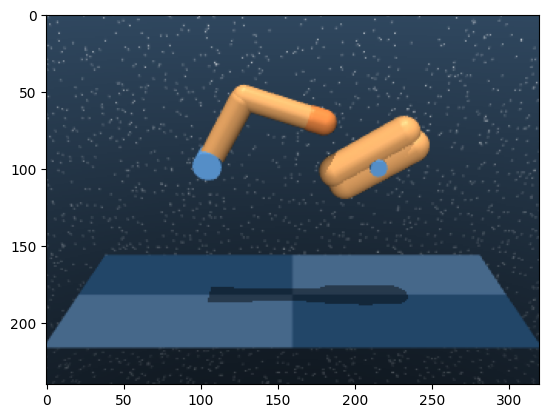

In [1]:
# flake8: noqa: F401
# type: ignore
import os
os.environ["MUJOCO_GL"] = "egl"
import sys
sys.path.append("..")
import matplotlib.pyplot as plt

from carl.envs.dmc.carl_dm_finger import CARLDmcFingerEnv

n_steps = 10
carl_env = CARLDmcFingerEnv(
    task="spin_context",
    contexts=None,
    context_mask=[],
    hide_context=False,
    dict_observation_space=True,
)
for i in range(n_steps):
    action = carl_env.action_space.sample()
    state, reward, done, info = carl_env.step(action=action)

render = lambda: plt.imshow(carl_env.render(mode="rgb_array"))
s = carl_env.reset()
render()
# plt.savefig("dm_render.png")
action = carl_env.action_space.sample()
state, reward, done, info = carl_env.step(action=action)
print("state", state, type(state))


plt.show()


In [3]:
from __future__ import annotations
import sys
sys.path.append("..")

import numpy as np
from dm_control.rl import control  # type: ignore
from dm_control.suite.finger import (  # type: ignore
    _CONTROL_TIMESTEP,
    _DEFAULT_TIME_LIMIT,
    _EASY_TARGET_SIZE,
    _HARD_TARGET_SIZE,
    SUITE,
    Physics,
    Spin,
    Turn,
    get_model_and_assets,
)

from carl.envs.dmc.dmc_tasks.utils import adapt_context  # type: ignore
from carl.utils.types import Context

def spin_context(
    context: Context = {},
    context_mask: list = [],
    time_limit: float = _DEFAULT_TIME_LIMIT,
    random: np.random.RandomState | int | None = None,
    environment_kwargs: dict | None = None,
    xml_string = None
) -> control.Environment:
    """Returns the Spin task."""
    xml_string_, assets = get_model_and_assets()
    if xml_string is None:
        xml_string = xml_string_
    if context != {}:
        xml_string = adapt_context(
            xml_string=xml_string, context=context, context_mask=context_mask
        )
    physics = Physics.from_xml_string(xml_string, assets)
    task = Spin(random=random)
    environment_kwargs = environment_kwargs or {}
    return control.Environment(
        physics,
        task,
        time_limit=time_limit,
        control_timestep=_CONTROL_TIMESTEP,
        **environment_kwargs,
    )

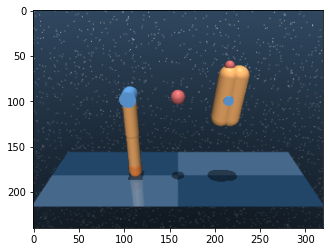

In [17]:
from carl.envs.dmc.wrappers import MujocoToGymWrapper
import matplotlib.pyplot as plt

# TODO change mass of finger tip (simulates different endeffectors), finger material, spinner material

# righ hand coordinate system. x right, y up, z into image. Order of coordinates in xml string: (x z y)

def get_finger_xml_string(
    limb_length_0: float = 0.17,
    limb_length_1: float = 0.16,
    spinner_radius: float = 0.04,
    spinner_length: float = 0.18,
) -> str:
    # Finger position
    x_finger = -0.2
    y_finger = 0.4

    # Spinner position
    x_spinner = 0.2
    y_spinner = 0.4

    # Spinner geometry
    spinner_half_length = spinner_length / 2
    spinner_tip_radius = 0.02
    distance_spinner_tip_to_captop = 0.06
    y_spinner_tip = spinner_half_length + distance_spinner_tip_to_captop - spinner_tip_radius  # originally 0.13

    # check constraints
    min_distance_to_finger = (x_spinner - x_finger) - spinner_length
    if min_distance_to_finger < 0:
        raise ValueError(f"Distance finger to spinner ({min_distance_to_finger}) not big enough, spinner can't spin. Decrease spinner_length ({spinner_length}).")


    proximal_to = - limb_length_0
    xml_string = f"""
     <mujoco model="finger">
      <include file="./common/visual.xml"/>
      <include file="./common/skybox.xml"/>
      <include file="./common/materials.xml"/>

      <option timestep="0.01" cone="elliptic" iterations="200">
        <flag gravity="disable"/>
      </option>

      <default>
        <geom solimp="0 0.9 0.01" solref=".02 1"/>
        <joint type="hinge" axis="0 -1 0"/>
        <motor ctrllimited="true" ctrlrange="-1 1"/>
        <default class="finger">
          <joint damping="2.5" limited="true"/>
          <site type="ellipsoid" size=".025 .03 .025" material="site" group="3"/>
        </default>
      </default>

      <worldbody>
        <light name="light" directional="true" diffuse=".6 .6 .6" pos="0 0 2" specular=".3 .3 .3"/>
        <geom name="ground" type="plane" pos="0 0 0" size=".6 .2 10" material="grid"/>
        <camera name="cam0" pos="0 -1 .8" xyaxes="1 0 0 0 1 2"/>
        <camera name="cam1" pos="0 -1 .4" xyaxes="1 0 0 0 0 1" />

        <body name="proximal" pos="{x_finger} 0 {y_finger}" childclass="finger">
          <geom name="proximal_decoration" type="cylinder" fromto="0 -.033 0 0 .033 0" size=".034" material="decoration"/>
          <joint name="proximal" range="-110 110" ref="-90"/>
          <geom name="proximal" type="capsule" material="self" size=".03" fromto="0 0 0 0 0 {proximal_to}"/>
          <body name="distal" pos="0 0 {proximal_to - 0.01}" childclass="finger">
            <joint name="distal" range="-110 110"/>
            <geom name="distal" type="capsule" size=".028" material="self" fromto="0 0 0 0 0 {-limb_length_1}" contype="0" conaffinity="0"/>
            <geom name="fingertip" type="capsule" size=".03" material="effector" fromto="0 0 {-limb_length_1 - 0.03} 0 0 {-limb_length_1 - 0.001}"/>
            <site name="touchtop" pos=".01 0 -.17"/>
            <site name="touchbottom" pos="-.01 0 -.17"/>
          </body>
        </body>

        <body name="spinner" pos="{x_spinner} 0 {y_spinner}">
          <joint name="hinge" frictionloss=".1" damping=".5"/>
          <geom name="cap1" type="capsule" size="{spinner_radius}" fromto="{spinner_radius/2} 0 {-spinner_half_length} {spinner_radius} 0 {spinner_half_length}" material="self"/>
          <geom name="cap2" type="capsule" size="{spinner_radius}" fromto="{-spinner_radius/2} 0 {-spinner_half_length} 0 0 {spinner_half_length}" material="self"/>
          <site name="tip" type="sphere"  size="{spinner_tip_radius}" pos="0 0 {y_spinner_tip}" material="target"/>
          <geom name="spinner_decoration" type="cylinder" fromto="0 -.045 0 0 .045 0" size="{spinner_radius/2}" material="decoration"/>
        </body>

        <site name="target" type="sphere" size=".03" pos="0 0 .4" material="target"/>
      </worldbody>

      <actuator>
        <motor name="proximal" joint="proximal" gear="30"/>
        <motor name="distal" joint="distal" gear="15"/>
      </actuator>

      <!-- All finger observations are functions of sensors. This is useful for finite-differencing. -->
      <sensor>
        <jointpos name="proximal" joint="proximal"/>
        <jointpos name="distal" joint="distal"/>
        <jointvel name="proximal_velocity" joint="proximal"/>
        <jointvel name="distal_velocity" joint="distal"/>
        <jointvel name="hinge_velocity" joint="hinge"/>
        <framepos name="tip" objtype="site" objname="tip"/>
        <framepos name="target" objtype="site" objname="target"/>
        <framepos name="spinner" objtype="xbody" objname="spinner"/>
        <touch name="touchtop" site="touchtop"/>
        <touch name="touchbottom" site="touchbottom"/>
        <framepos name="touchtop_pos" objtype="site" objname="touchtop"/>
        <framepos name="touchbottom_pos" objtype="site" objname="touchbottom"/>
      </sensor>

    </mujoco>
    """
    return xml_string

xml_string = get_finger_xml_string()
env = spin_context(xml_string=xml_string, random=3)
env = MujocoToGymWrapper(env)
img = env.render(mode="rgb_array")
plt.imshow(img)
plt.show()

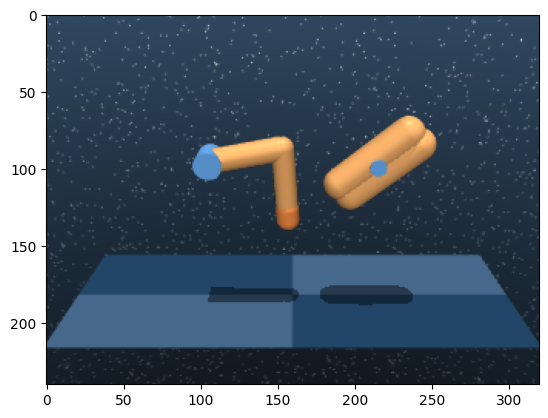

In [5]:
import matplotlib.pyplot as plt
from carl.envs import CARLDmcFingerEnv

env = CARLDmcFingerEnv(contexts={0: {"spinner_length": 0.2}})
s = env.reset()
img = env.render(mode="rgb_array")
plt.imshow(img)
plt.show()